In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.stats import zscore
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_auc_score, roc_curve

In [2]:
# Import the train & test data
train = pd.read_csv("C:\\Users\\Prasanna KM\\Downloads\\titanic\\train.csv")
df_test = pd.read_csv("C:\\Users\\Prasanna KM\\Downloads\\titanic\\test.csv")
test = df_test.copy() # making a copy of test data to make predictions

In [3]:
# Let's check shape (number of rows, number of columns) of the train & test data
print("Train data - rows:",train.shape[0],", columns:", train.shape[1])
print()
print("Test data - rows:",test.shape[0],", columns:", test.shape[1])

Train data - rows: 891 , columns: 12

Test data - rows: 418 , columns: 11


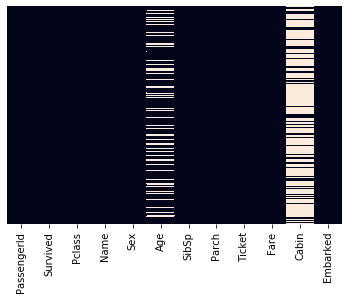

In [4]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False)
plt.show()

In [5]:
# Missing values in the train data
train.isnull().sum().sort_values(ascending = False)  ## using sort_values we can sort values in descending order

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [6]:
# Missing values in test data
test.isnull().sum().sort_values(ascending = False) 

Cabin          327
Age             86
Fare             1
Embarked         0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

0    549
1    342
Name: Survived, dtype: int64



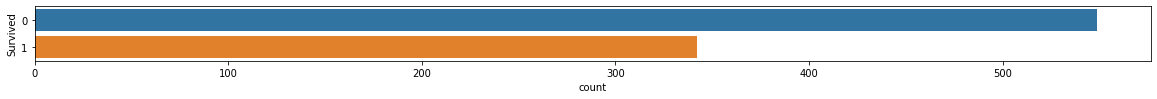

In [7]:
# How many people survived
print(train.Survived.value_counts())
print()
plt.figure(figsize=(20,1))
sns.countplot(y= "Survived", data = train)
plt.show()

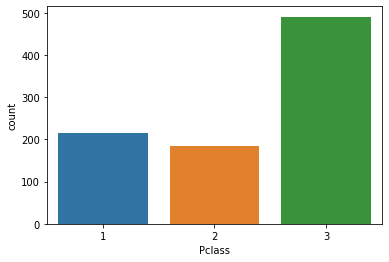

In [8]:
sns.countplot(train['Pclass'])
plt.show()

In [9]:
# Let's check missing values
train.Pclass.isnull().sum()

0

In [10]:
# Let's drop this Name & PassengerId from data
train.drop(columns = ["Name","PassengerId"], axis = 1, inplace = True)
test.drop(columns = ["Name","PassengerId"], axis = 1, inplace = True)

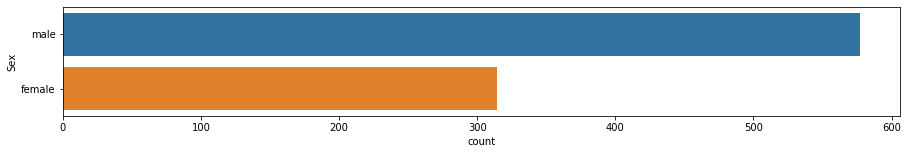

In [11]:
# Let's view the distribution of Sex
plt.figure(figsize=(15, 2))
sns.countplot(y="Sex", data=train);

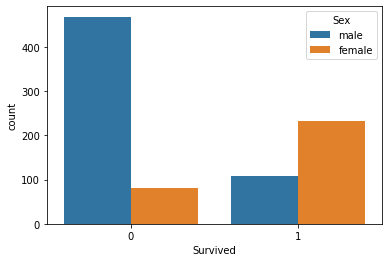

In [12]:
sns.countplot(x = 'Survived', hue = 'Sex', data = train)
plt.show()

In [13]:
# Let's check for missing values in train data
train.Sex.isnull().sum()

0

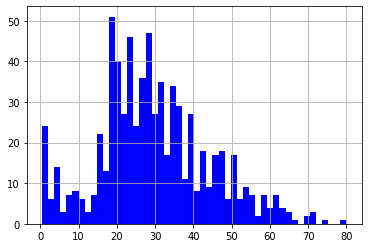

In [14]:
train['Age'].hist(bins = 50, color = 'blue')
plt.show()

In [15]:
# Let's check for missing values in Age feature
train.Age.isnull().sum()

177

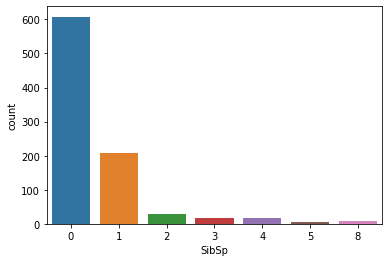

In [16]:
sns.countplot(train['SibSp'])
plt.show()

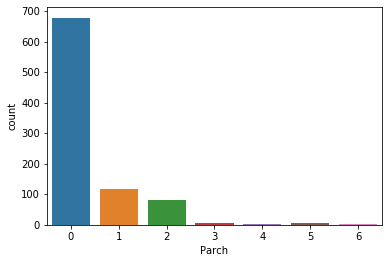

In [17]:
sns.countplot(train['Parch'])
plt.show()

In [18]:
# Let's see how many kind's of ticket's are there
train.Ticket.value_counts()

347082                7
CA. 2343              7
1601                  7
347088                6
3101295               6
                     ..
113804                1
STON/O2. 3101290      1
SOTON/O.Q. 3101307    1
250643                1
113807                1
Name: Ticket, Length: 681, dtype: int64

In [19]:
# How many kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


In [20]:
# Let's drop this feature from our dataset
train.drop("Ticket", axis = 1, inplace = True)
test.drop("Ticket", axis = 1, inplace = True)

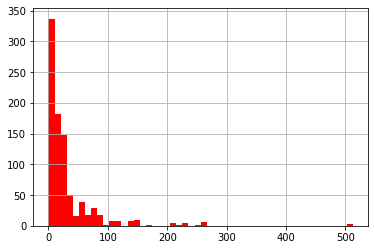

In [21]:
train['Fare'].hist(bins = 50, color = 'red')
plt.show()

In [22]:
# Let's drop this feature because we already have class
train.drop("Fare", axis = 1, inplace = True)
test.drop("Fare", axis = 1, inplace = True)

In [23]:
train.Cabin.value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
F33            3
D              3
              ..
D15            1
D19            1
D46            1
B79            1
B78            1
Name: Cabin, Length: 147, dtype: int64

In [24]:
# Let's drop Cabin feature
train.drop("Cabin", axis = 1, inplace = True)
test.drop("Cabin", axis =1, inplace = True)

In [25]:
# Let's check what kind of values are in Embarked
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

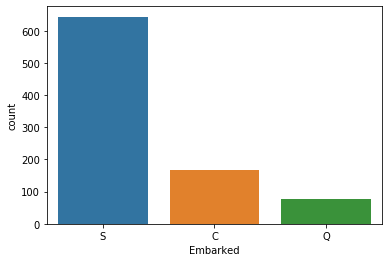

In [26]:
sns.countplot(train['Embarked'])
plt.show()

In [27]:
# Let's check for missing values in Embarked
train["Embarked"].isnull().sum()

2

In [28]:
# Let's remove Embarked rows which are missing values
print(len(train))
train = train.dropna(subset=['Embarked'])
print(len(train))

891
889


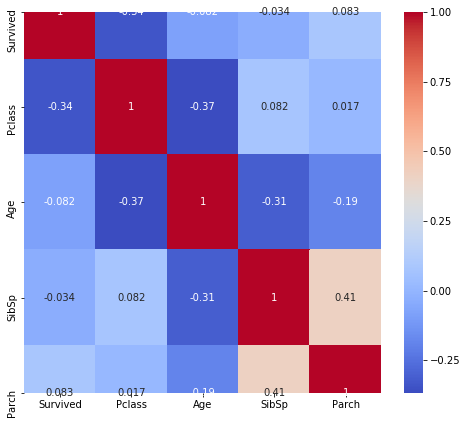

In [29]:
# Let's see features correlation matrix using heatmap
plt.figure(figsize=(8,7))
sns.heatmap(train.corr(), annot = True, cmap = "coolwarm")
plt.show()

In [30]:
## Let's impute missing values of Age feature using Pclass since they have the highest correlation in absolute numbers
train['Age'] = train.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))

In [31]:
print(train["Age"].isnull().sum())
print(test["Age"].isnull().sum())

0
0


In [32]:
#Let's convert the categorical variables into dummy/indicator variables using get_dummies() 
train = pd.get_dummies(data = train, columns = ["Sex", "Embarked", "Pclass"])
test = pd.get_dummies(data = test, columns = ["Sex", "Embarked", "Pclass"])

In [33]:
# Let's split the dataset into data and labels
X_train = train.drop("Survived", axis = 1)  # data
y_train = train["Survived"] # labels

In [34]:
# Let's check the shape of the data without labels
X_train.shape

(889, 11)

In [35]:
# Let's check the shape of the labels
y_train.shape

(889,)

In [36]:
# Let's write a function that runs the requested algorithm and returns the accuracy metrics
def fit_model(algo, X_train, y_train, cv):
    
    model = algo.fit(X_train, y_train)    
    y_pred = algo.predict(X_train)    
    accuracy = round(accuracy_score(y_train, y_pred) * 100 , 2)
    
    #cross validation
    y_pred_cv = cross_val_predict(algo, X_train, y_train, cv = cv)
    # cross validation accuracy
    accuracy_cv = round(accuracy_score(y_train, y_pred_cv) * 100 , 2)
    
    return y_pred_cv, accuracy, accuracy_cv

#### Logistic regression

In [42]:
# Logistic Regression

y_pred_cv_lr, accuracy_lr, accuracy_cv_lr = fit_model(LogisticRegression(random_state = 3),
                                                     X_train, y_train, 10)

print("Accuracy : ",accuracy_lr)
print("Accuracy CV :",accuracy_cv_lr)

C:\Users\Prasanna KM\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Prasanna KM\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

Accuracy :  80.65
Accuracy CV : 80.43


#### Random forest

In [38]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 100, random_state = 3)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)

print('Confusion Matrix : ','\n', confusion_matrix(y_train, y_train_pred))
print()
print("Accuracy : ", round(accuracy_score(y_train, y_train_pred) * 100, 2))

Confusion Matrix :  
 [[532  17]
 [ 39 301]]

Accuracy :  93.7


In [41]:
# let's optimize hyperparameters in random forest classifier
from scipy.stats import randint as sp_randint
rfc = RandomForestClassifier(random_state=3)

params = {'n_estimators' : sp_randint(50,200),
         'max_depth' : sp_randint(2,100),
          'max_depth' : sp_randint(2,100),
         'min_samples_split' : sp_randint(2,100),
         'min_samples_leaf' : sp_randint(1,200),
         'criterion' : ['gini', 'entropy']}

# RandomizedSearchCV
rsearch_rfc = RandomizedSearchCV(rfc, param_distributions = params, n_iter = 100, cv = 3, scoring = 'roc_auc', n_jobs = -1,\
                             return_train_score = True, random_state = 3)

rsearch_rfc.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [40]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [43]:
# Print best hyperparameters
rsearch_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 35,
 'min_samples_leaf': 16,
 'min_samples_split': 15,
 'n_estimators': 160}

In [44]:
# let's fit our model to the training set with our best hyperparameters
rfc = RandomForestClassifier(**rsearch_rfc.best_params_, random_state = 3)

rfc.fit(X_train, y_train)

y_train_pred = rfc.predict(X_train)

print('Confusion Matrix : ','\n', confusion_matrix(y_train, y_train_pred))
print()
print("Accuracy : ", round(accuracy_score(y_train, y_train_pred) * 100, 2))

Confusion Matrix :  
 [[516  33]
 [125 215]]

Accuracy :  82.23


In [45]:
# Let's make a prediction on the test dataset using our random forest

y_test_pred = rfc.predict(test)

In [46]:
y_test_pred[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
      dtype=int64)

In [47]:
# Let's create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived'] = y_test_pred # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [48]:
# Let's check shape of test and submission DataFrame
print(submission.shape)
print(df_test.shape)

(418, 2)
(418, 11)


In [49]:
# Let's convert submisison dataframe to csv

submission.to_csv('C:\\Users\\Prasanna KM\\Downloads\\titanic\\Submission\\submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [50]:
# let's check the submission csv
submissions_check = pd.read_csv("C:\\Users\\Prasanna KM\\Downloads\\titanic\\Submission\\submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
